In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
from copy import deepcopy

NUMBER_OF_COUNTIES = 3143

In [2]:
budget = 10000000
N = 4000
risk = 0.8

print(budget, N, risk)

from readData import *
from rent_estimation import calculate_rent_estimation

income = getIncome()
income.drop(['MedianIncome','MedianIncomeRatio'],axis=1,inplace=True)
populations = getPopulation()
populations = populations[['State','County','2024']]
populations.rename({'2024':'Population'},axis=1,inplace=True)
rent = calculate_rent_estimation()
rent = rent[['State','County','Estimated_annual_rent']]
minwage = getMinWage()

data = populations.merge(income)
data = data.merge(rent)
data = data.merge(minwage)
data[' MinWage'] = data[' MinWage'] \
    .str.replace(' 15.50/16.50', ' 16.50') \
    .str.strip()
data[' MinWage'] = data[' MinWage'].astype(float)
data.rename(columns={
    ' MinWage':'MinWage',
}, inplace=True)
data

10000000 4000 0.8
Average Rent Per Sqft: 92.93
Average Annual Rent: 185857.18


c:\MY FILES\UMD\Sem 4\MSML604 Optimization\Project\optimization-location-intelligence\rent_estimation.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Commercial_rent_per_sqft_year'].fillna(avg_rent_per_sqft, inplace=True)
c:\MY FILES\UMD\Sem 4\MSML604 Optimization\Project\optimization-location-intelligence\rent_estimation.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace 

,State,County,Population,CountyID,MeanIncome,MeanIncomeRatio,Estimated_annual_rent,MinWage
0,Alabama,Autauga,61464,0500000US01001,93367,0.411925,184682.27,7.25
1,Alabama,Baldwin,261608,0500000US01003,100105,0.441653,282247.68,7.25
2,Alabama,Barbour,24358,0500000US01005,64745,0.285648,106381.32,7.25
3,Alabama,Bibb,22258,0500000US01007,67735,0.298840,146669.94,7.25
4,Alabama,Blount,60163,0500000US01009,79203,0.349435,168697.13,7.25
...,...,...,...,...,...,...,...,...
3138,Wyoming,Sweetwater,41273,0500000US56037,98608,0.435048,211876.05,7.25
3139,Wyoming,Teton,23272,0500000US56039,185173,0.816964,1621554.10,7.25
3140,Wyoming,Uinta,20621,0500000US56041,89995,0.397048,235265.57,7.25
3141,Wyoming,Washakie,7662,0500000US56043,80444,0.354910,184506.77,7.25


In [3]:
budget = budget
N = N
risk = risk
totalPop = data['Population']
IR = data['MeanIncomeRatio']
minwage = data['MinWage']
rent = data['Estimated_annual_rent']

In [41]:
model = pyo.ConcreteModel()
model.counties = pyo.RangeSet(0, NUMBER_OF_COUNTIES - 1) # Number of counties
model.x = pyo.Var(model.counties, 
                  # domain=pyo.NonNegativeIntegers, 
                  domain=pyo.NonNegativeReals,
                  name='x') # Number of stores in each county
model.P = pyo.Var(model.counties, 
                #   domain=pyo.NonNegativeIntegers, 
                  domain=pyo.NonNegativeReals,
                  name='P',
                  bounds=(1, 50)) # Price in each county
model.budget = pyo.Param(initialize=budget) # Budget for owning restaurants
model.N = pyo.Param(initialize=N) # Maximum number of stores to open
model.risk = pyo.Param(initialize=risk) # Total acceptable risk ratio per location (cost/revenue)
model.totalPop = pyo.Param(model.counties, initialize=totalPop) # Total population in county
model.IR = pyo.Param(model.counties, initialize=IR) # Income Ratio relative to maximum county income
model.minwage = pyo.Param(model.counties, initialize=minwage) # Minimum wage in county
model.rent = pyo.Param(model.counties, initialize=rent) # Rent of restaurant
model.employees = pyo.Param(initialize=15) # Number of employees in restaurant

In [42]:
model.del_component('demand')  # Remove the existing demand component if it exists
def demand_rule(model, i):
    # Calculate demand based on the given formula
    return model.totalPop[i] / model.x[i] * pyo.exp(-0.003 * model.P[i]**2)

model.demand = pyo.Expression(model.counties, rule=demand_rule)

```python
for i in model.component_objects(pyo.Expression, active=True):
    print(i)
```

In [43]:
model.del_component('revnue')
def revenue_rule(model, i):
    # Calculate revenue based on the given formula
    return model.P[i]**(pyo.sqrt(model.IR[i])) * model.demand[i]

model.revenue = pyo.Expression(model.counties, rule=revenue_rule)

In [44]:
model.del_component('loss')
def loss_rule(model, i):
    # Calculate losses based on the given formula
    return 0.082 * model.revenue[i]

model.loss = pyo.Expression(model.counties, rule=loss_rule)

model.del_component('costs')
def costs_rule(model, i):
    # Calculate costs based on the given formula
    return model.minwage[i] * model.employees + model.rent[i] + model.loss[i]

model.costs = pyo.Expression(model.counties, rule=costs_rule)

In [45]:
model.del_component('budget_constraint')
def budget_constraint_rule(model):
    # Calculate total costs based on the given formula
    return model.budget - sum(model.x[i] * model.costs[i] 
                              for i in model.counties) >= 0

model.budget_constraint = pyo.Constraint(
    rule=budget_constraint_rule
) # Budget constraint

model.del_component('total_stores_constraint')
def total_stores_constraint_rule(model):
    return model.N - sum(model.x[i] 
                         for i in model.counties) >= 0

model.total_stores_constraint = pyo.Constraint(
    rule=total_stores_constraint_rule
) # Maximum number of stores constraint

model.del_component('risk_constraint')
def risk_constraint_rule(model, i):
    # Calculate total revenue based on the given formula
    return model.risk - model.costs[i] / model.revenue[i] >= 0

model.risk_constraint = pyo.Constraint(
    model.counties,
    rule=risk_constraint_rule
) # Risk constraint

# model.c.add(model.x >= 0) # Number of stores must be positive
# model.c.add(model.P >= 10) # Price must be positive
# model.c.add(model.P <= 50) # Price must be positive

C:\Users\Peeyush\AppData\Local\Temp\ipykernel_5932\3600962571.py:5: RuntimeWarning: overflow encountered in exp
  func = lambda x: 1 / (1 + np.exp(-k_val * x))


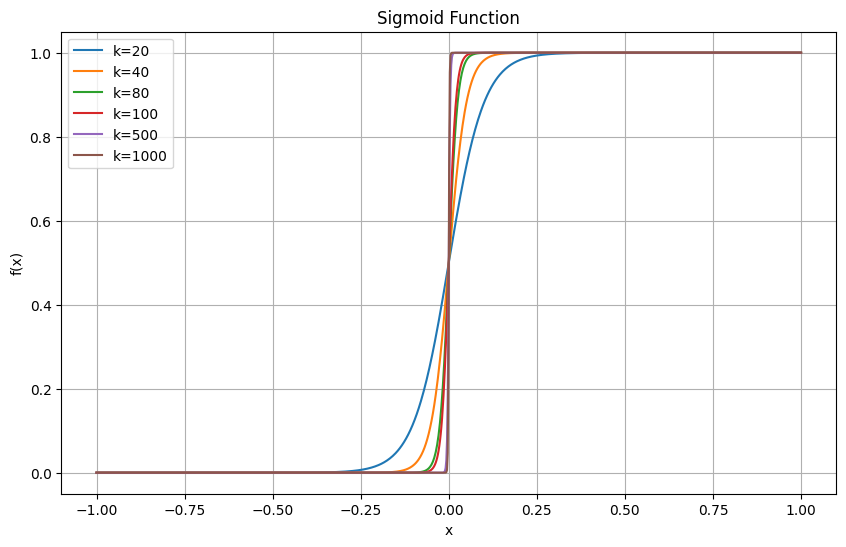

In [46]:
import matplotlib.pyplot as plt
k = [20, 40, 80, 100, 500, 1000]
plt.figure(figsize=(10, 6))
for k_val in k:
    func = lambda x: 1 / (1 + np.exp(-k_val * x))
    points = np.linspace(-1, 1, 1000)
    func_values = func(points)
    plt.plot(points, func_values, label=f'k={k_val}')   
    # plt.legend([f'k={k_val}'])
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.show()

In [47]:
model.del_component('objective')
def no_shops_rule(model, i):
    return 1 / (1 + pyo.exp(-1000 * model.x[i]))

def objective_rule(model):
    # Calculate the objective function based on the given formula
    cost_minus_loss_times_x = sum(model.x[i] * 
                        (
                            model.minwage[i] * model.employees 
                            + model.rent[i]
                        )
                       for i in model.counties)
    revenue_minus_loss_times_x = sum(
                no_shops_rule(model, i) 
                 * 0.918 * model.totalPop[i] 
                 * pyo.exp(-0.003 * model.P[i]**2) 
                 * model.P[i]**pyo.sqrt(model.IR[i])
                 for i in model.counties)
    return revenue_minus_loss_times_x - cost_minus_loss_times_x

model.objective = pyo.Objective(
    rule=objective_rule,
    sense=pyo.maximize
) # Get objective function

In [48]:
solver = pyo.SolverFactory('ipopt') # Create solver
result = solver.solve(model, tee=True) # Solve the model
print("Status:", result.solver.termination_condition)

Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    15715
Number of nonzeros in Lagrangian Hessian.............:     9429

Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating objective gradient at user provided starting point.
  No scaling factor for objective function computed!
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
Error evaluating Jacobian of inequality constraints 

In [22]:
print("Objective value:", pyo.value(model.objective))
# print("Number of stores in each county:")
# for i in model.counties:
#     print(f"County {i}: {pyo.value(model.x[i])} stores")
# print("Price in each county:")
# for i in model.counties:
#     print(f"County {i}: ${pyo.value(model.P[i])}")
# print("Total cost in each county:")
# for i in model.counties:
#     print(f"County {i}: ${pyo.value(model.x[i] * model.costs[i])}")
# print("Total revenue in each county:")
# for i in model.counties:
#     print(f"County {i}: ${pyo.value(model.revenue[i])}")
# print("Total loss in each county:")
# for i in model.counties:
#     print(f"County {i}: ${pyo.value(model.loss[i])}")
print("Total budget used:")
print(f"${pyo.value(sum(model.x[i] * model.costs[i] for i in model.counties))}")
print("Total number of stores opened:")
print(f"{pyo.value(sum(model.x[i] for i in model.counties))} stores")
print("Total risk ratio:")
print(f"{pyo.value(sum(model.costs[i] / model.revenue[i] for i in model.counties))}")
print("Total number of counties with stores:")
print(f"{len([i for i in model.counties if pyo.value(model.x[i]) > 0])} counties")
print("Total number of counties without stores:")
print(f"{len([i for i in model.counties if pyo.value(model.x[i]) == 0])} counties")
print("Total number of counties with revenue:")
print(f"{len([i for i in model.counties if pyo.value(model.revenue[i]) > 0])} counties")
print("Total number of counties without revenue:")
print(f"{len([i for i in model.counties if pyo.value(model.revenue[i]) == 0])} counties")
print("Total number of counties with loss:")
print(f"{len([i for i in model.counties if pyo.value(model.loss[i]) > 0])} counties")
print("Total number of counties without loss:")
print(f"{len([i for i in model.counties if pyo.value(model.loss[i]) == 0])} counties")
print("Total number of counties with costs:")
print(f"{len([i for i in model.counties if pyo.value(model.costs[i]) > 0])} counties")
print("Total number of counties without costs:")
print(f"{len([i for i in model.counties if pyo.value(model.costs[i]) == 0])} counties")
print("Total number of counties with budget:")
print(f"{len([i for i in model.counties if pyo.value(model.budget) > 0])} counties")
print("Total number of counties without budget:")
print(f"{len([i for i in model.counties if pyo.value(model.budget) == 0])} counties")
print("Total number of counties with risk:")
print(f"{len([i for i in model.counties if pyo.value(model.risk) > 0])} counties")
print("Total number of counties without risk:")
print(f"{len([i for i in model.counties if pyo.value(model.risk) == 0])} counties")
print("Total number of counties with total population:")
print(f"{len([i for i in model.counties if pyo.value(model.totalPop[i]) > 0])} counties")
print("Total number of counties without total population:")
print(f"{len([i for i in model.counties if pyo.value(model.totalPop[i]) == 0])} counties")
print("Total number of counties with income ratio:")
print(f"{len([i for i in model.counties if pyo.value(model.IR[i]) > 0])} counties")
print("Total number of counties without income ratio:")
print(f"{len([i for i in model.counties if pyo.value(model.IR[i]) == 0])} counties")


Objective value: 310643894.2259326
Total budget used:
$27748141.04609663
Total number of stores opened:
-3.142999997961191e-05 stores
Total risk ratio:
257.72550978140043
Total number of counties with stores:
0 counties
Total number of counties without stores:
0 counties
Total number of counties with revenue:
0 counties
Total number of counties without revenue:
0 counties
Total number of counties with loss:
0 counties
Total number of counties without loss:
0 counties
Total number of counties with costs:
0 counties
Total number of counties without costs:
0 counties
Total number of counties with budget:
3143 counties
Total number of counties without budget:
0 counties
Total number of counties with risk:
3143 counties
Total number of counties without risk:
0 counties
Total number of counties with total population:
3143 counties
Total number of counties without total population:
0 counties
Total number of counties with income ratio:
3143 counties
Total number of counties without income rat